6.5147410170609685


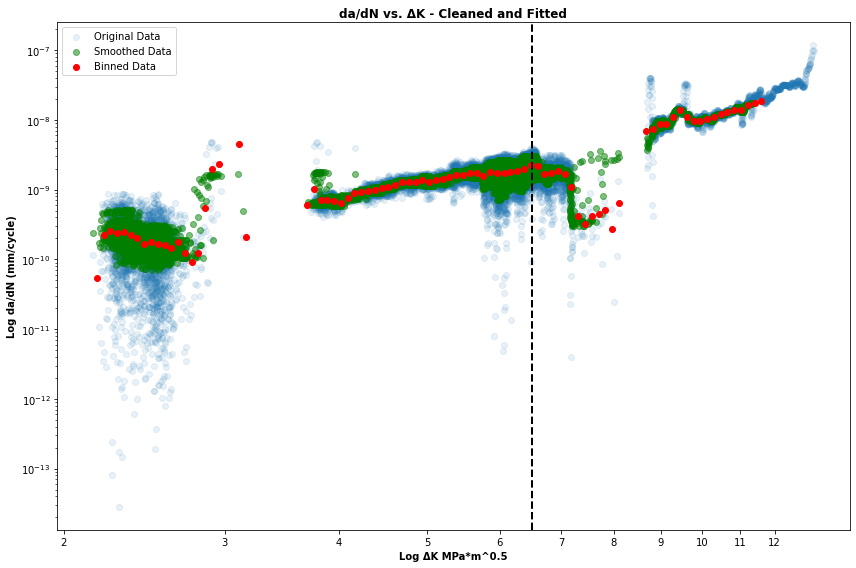

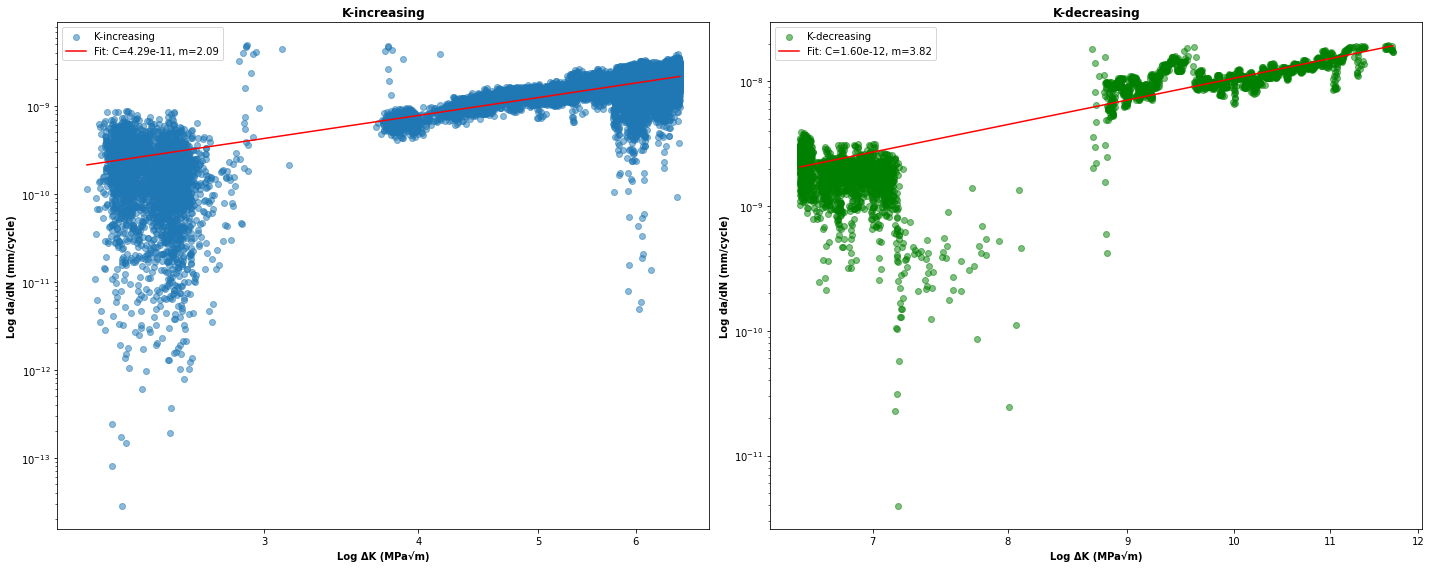

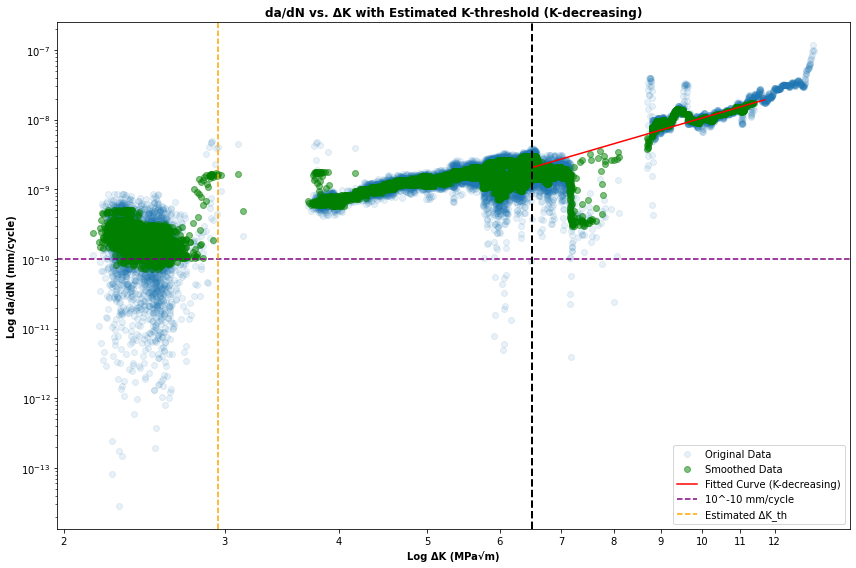

Estimated ΔK_th: 2.9505 MPa√m
Paris Law parameters for K-decreasing portion: C = 1.60e-12, m = 3.82


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.optimize import curve_fit

# Load the Excel file
# Replace 'your_file.xlsx' with the path to your Excel file
df = pd.read_csv(r'C:\Users\n\OneDrive - The Ohio State University\Project\DCPD\Test 1 - Sample B1\B1\Output\Test 1_frama_data.csv')

# Multiply 'DK' column by 10^-6
df['DK'] = df['DK'] * 1e-6

# 1. Remove outliers using Z-score
def remove_outliers(df, columns, z_threshold=3):
    df_copy = df.copy()
    for col in columns:
        z_scores = np.abs(stats.zscore(df_copy[col], nan_policy='omit'))
        df_copy = df_copy[z_scores < z_threshold]
    return df_copy

# 2. Clean data: remove NaN and non-positive values
def clean_data(df, columns):
    df_clean = df.dropna(subset=columns)
    for col in columns:
        df_clean = df_clean[df_clean[col] > 0]
    return df_clean

# Apply cleaning steps
df_cleaned = clean_data(df, ['da_dN', 'DK'])
df_cleaned = remove_outliers(df_cleaned, ['da_dN', 'DK'])

# Check if we have enough data to proceed
if len(df_cleaned) < 10:
    raise ValueError("Not enough valid data points after cleaning.")

# 3. Apply moving average
window_size = min(50, len(df_cleaned) // 10)  # Adjust window size based on data length
df_cleaned['da_dN_smooth'] = df_cleaned['da_dN'].rolling(window=window_size, center=True).mean()

# 4. Bin the data
def bin_data(x, y, num_bins=100):
    bins = np.logspace(np.log10(x.min()), np.log10(x.max()), num_bins)
    binned_data = stats.binned_statistic(x, y, statistic='mean', bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers, binned_data.statistic

DK_binned, da_dN_binned = bin_data(df_cleaned['DK'], df_cleaned['da_dN'])


# Fit the binned data
valid_mask = ~np.isnan(da_dN_binned) & (da_dN_binned > 0) & (DK_binned > 0)
popt, _ = curve_fit(paris_law, DK_binned[valid_mask], da_dN_binned[valid_mask], p0=[1e-12, 3])

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(df['DK'], df['da_dN'], alpha=0.1, label='Original Data')
plt.scatter(df_cleaned['DK'], df_cleaned['da_dN_smooth'], 
            alpha=0.5, color='green', label='Smoothed Data')
plt.scatter(DK_binned[valid_mask], da_dN_binned[valid_mask], color='red', label='Binned Data')

DK_range = np.logspace(np.log10(df_cleaned['DK'].min()), np.log10(df_cleaned['DK'].max()), 100)

plt.xscale('log')
plt.yscale('log')

# Modify x-axis formatting
ax = plt.gca()
x_ticks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax.xaxis.set_major_locator(FixedLocator(x_ticks))
ax.xaxis.set_major_formatter(FixedFormatter([str(x) for x in x_ticks]))

plt.xlabel('Log ΔK MPa*m^0.5', fontweight='bold')
plt.ylabel('Log da/dN (mm/cycle)', fontweight='bold')
plt.title('da/dN vs. ΔK - Cleaned and Fitted', fontweight='bold')
plt.legend()
# Get the x-value (DK) at row 5377 (transition from k-dec to k-incr)
x_value = df.iloc[5375]['DK']
print(x_value)
# Add vertical dashed red line
plt.axvline(x=x_value, color='black', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()


# Define the Paris law function
def paris_law(DK, C, m):
    return C * (DK ** m)


# Identify the transition point
transition_point = df.iloc[5375]['DK']

# Split the data into K-decreasing and K-increasing portions
df_k_decreasing = df_cleaned[df_cleaned['DK'] <= transition_point]
df_k_increasing = df_cleaned[df_cleaned['DK'] > transition_point]

# Fit Paris law to K-decreasing data
popt_dec, _ = curve_fit(paris_law, df_k_decreasing['DK'], df_k_decreasing['da_dN'], p0=[1e-12, 3])

# Fit Paris law to K-increasing data
popt_inc, _ = curve_fit(paris_law, df_k_increasing['DK'], df_k_increasing['da_dN'], p0=[1e-12, 3])

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot K-decreasing portion
ax1.scatter(df_k_decreasing['DK'], df_k_decreasing['da_dN'], alpha=0.5, label='K-increasing')
DK_fit_dec = np.logspace(np.log10(df_k_decreasing['DK'].min()), np.log10(df_k_decreasing['DK'].max()), 100)
ax1.plot(DK_fit_dec, paris_law(DK_fit_dec, *popt_dec), 'r-', label=f'Fit: C={popt_dec[0]:.2e}, m={popt_dec[1]:.2f}')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Log ΔK (MPa√m)', fontweight='bold')
ax1.set_ylabel('Log da/dN (mm/cycle)', fontweight='bold')
ax1.set_title('K-increasing', fontweight='bold')
ax1.legend()

# Plot K-increasing portion
ax2.scatter(df_k_increasing['DK'], df_k_increasing['da_dN'], alpha=0.5, color='green', label='K-decreasing')
DK_fit_inc = np.logspace(np.log10(df_k_increasing['DK'].min()), np.log10(df_k_increasing['DK'].max()), 100)
ax2.plot(DK_fit_inc, paris_law(DK_fit_inc, *popt_inc), 'r-', label=f'Fit: C={popt_inc[0]:.2e}, m={popt_inc[1]:.2f}')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Log ΔK (MPa√m)', fontweight='bold')
ax2.set_ylabel('Log da/dN (mm/cycle)', fontweight='bold')
ax2.set_title('K-decreasing', fontweight='bold')
ax2.legend()

# Format x-axis for both plots
for ax in [ax1, ax2]:
    x_ticks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    ax.xaxis.set_major_locator(FixedLocator(x_ticks))
    ax.xaxis.set_major_formatter(FixedFormatter([str(x) for x in x_ticks]))

plt.tight_layout()
plt.show()



# Select the K-decreasing portion of the data (right half, after the transition point)
k_decreasing_data = df_cleaned[df_cleaned['DK'] > transition_point]

# Fit the curve to the K-decreasing portion
popt, _ = curve_fit(paris_law, k_decreasing_data['DK'], k_decreasing_data['da_dN'], p0=[1e-12, 3])

# Generate points for the fitted curve
DK_fit = np.logspace(np.log10(transition_point), np.log10(k_decreasing_data['DK'].max()), 100)
da_dN_fit = paris_law(DK_fit, *popt)

# Extrapolate to find K-threshold (where da/dN = 1e-10 mm/cycle)
DK_th = (1e-10 / popt[0]) ** (1 / popt[1])

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(df['DK'], df['da_dN'], alpha=0.1, label='Original Data')
plt.scatter(df_cleaned['DK'], df_cleaned['da_dN_smooth'], 
            alpha=0.5, color='green', label='Smoothed Data')
plt.plot(DK_fit, da_dN_fit, color='red', label='Fitted Curve (K-decreasing)')
plt.axhline(y=1e-10, color='purple', linestyle='--', label='10^-10 mm/cycle')
plt.axvline(x=DK_th, color='orange', linestyle='--', label='Estimated ΔK_th')

plt.xscale('log')
plt.yscale('log')

# Modify x-axis formatting
ax = plt.gca()
x_ticks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax.xaxis.set_major_locator(FixedLocator(x_ticks))
ax.xaxis.set_major_formatter(FixedFormatter([str(x) for x in x_ticks]))

plt.xlabel('Log ΔK (MPa√m)', fontweight='bold')
plt.ylabel('Log da/dN (mm/cycle)', fontweight='bold')
plt.title('da/dN vs. ΔK with Estimated K-threshold (K-decreasing)', fontweight='bold')
plt.legend()

# Add vertical dashed line for transition point
plt.axvline(x=transition_point, color='black', linestyle='--', linewidth=2, label='Transition Point')

plt.tight_layout()
plt.show()

print(f"Estimated ΔK_th: {DK_th:.4f} MPa√m")
print(f"Paris Law parameters for K-decreasing portion: C = {popt[0]:.2e}, m = {popt[1]:.2f}")


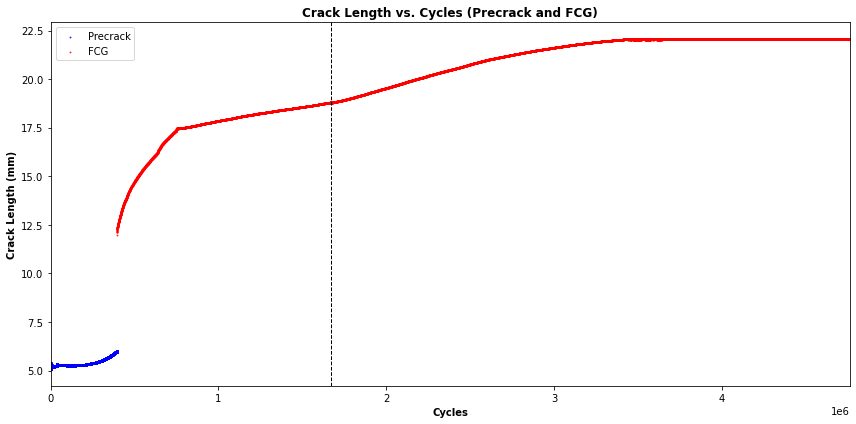

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# File path - replace with your actual file path
excel_file_path = r'C:\Users\n\OneDrive - The Ohio State University\Project\DCPD\Test 1 - Sample B1\B1\Heniken_DCPD_sampleB1.xlsx'

# Read specific columns from the first sheet (Sheet 1)
sheet1_data = pd.read_excel(excel_file_path, 
                            sheet_name=0, 
                            usecols=[1, 6],  # Columns B and G
                            names=['PC_N', 'PC_a'],
                            header=0)  # Assume the first row is header, adjust if needed

# Read specific columns from the second sheet (Sheet 2)
sheet2_data = pd.read_excel(excel_file_path, 
                            sheet_name=1, 
                            usecols=[0, 5, 10],  # Columns A, F, K
                            names=['FCG_N', 'FCG_a', 'DK'],
                            header=0)  # Assume the first row is header, adjust if needed

# Calculate the maximum cycle count and crack length from the precrack stage
max_precrack_cycles = sheet1_data['PC_N'].max()
final_precrack_length = sheet1_data['PC_a'].iloc[-1]

# Adjust the FCG cycle count and crack length
sheet2_data['FCG_N'] = sheet2_data['FCG_N'] + max_precrack_cycles
sheet2_data['FCG_a'] = sheet2_data['FCG_a'] + final_precrack_length

# Plot Precrack length and FCG crack length vs. Number of cycles
plt.figure(figsize=(12, 6))

# Plot precrack data
plt.scatter(sheet1_data['PC_N'], sheet1_data['PC_a'], s=1, alpha=0.7, label='Precrack', color='blue')

# Plot FCG data
plt.scatter(sheet2_data['FCG_N'], sheet2_data['FCG_a'], s=1, alpha=0.7, label='FCG', color='red')

# Add vertical dashed line at row 5377
row_5377_cycle = sheet2_data['FCG_N'].iloc[5376]  # Python uses 0-based indexing
plt.axvline(x=row_5377_cycle, color='black', linestyle='--', linewidth=1)

plt.xlabel('Cycles', fontweight='bold')
plt.ylabel('Crack Length (mm)', fontweight='bold')
plt.title('Crack Length vs. Cycles (Precrack and FCG)', fontweight='bold')
plt.legend()

# Adjust x-axis to show full range
plt.xlim(0, sheet2_data['FCG_N'].max())

plt.tight_layout()
plt.show()

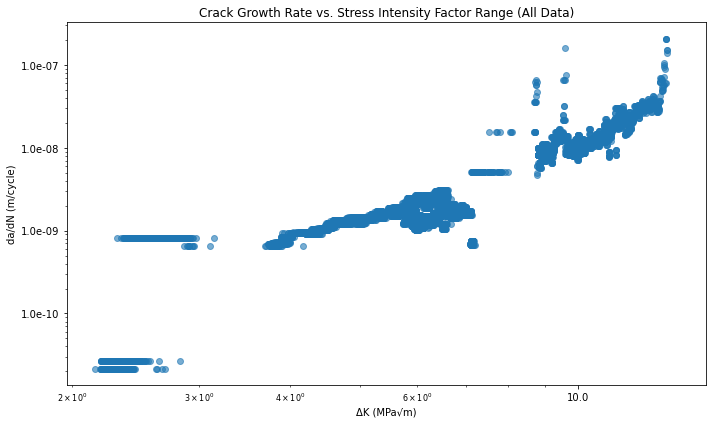

Linear regression results:
Slope: 2.8665
Intercept: -10.8833
R-squared: 0.5712
ΔK at da/dN = 10^-10 m/cycle: 2.0330 MPa√m


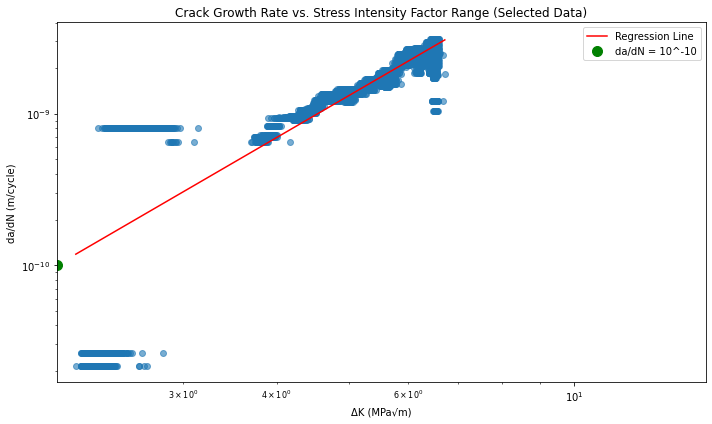

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.optimize import curve_fit

# File path - replace with your actual file path
excel_file_path = r'C:\Users\n\OneDrive - The Ohio State University\Project\DCPD\Test 1 - Sample B1\B1\Heniken_DCPD_sampleB1.xlsx'

# Read specific columns from the second sheet (Sheet 2)
sheet2_data = pd.read_excel(excel_file_path, 
                            sheet_name=1, 
                            usecols=[0, 5, 10, 11],  # Columns A, F, K, L
                            names=['FCG_N', 'FCG_a', 'DK', 'da_dN'],
                            header=0)  # Assume the first row is header

# Convert da/dN from mm/cycle to m/cycle
sheet2_data['da_dN'] = sheet2_data['da_dN'] * 0.001


# Function to create and show the plot
def create_plot(data, title, perform_regression=False):
    plt.figure(figsize=(10, 6))
    plt.loglog(data['DK'], data['da_dN'], 'o', alpha=0.6)
    plt.xlabel('ΔK (MPa√m)')
    plt.ylabel('da/dN (m/cycle)')
    plt.title(title)

    # Format x-axis (ΔK) to not use scientific notation and extend to 15
    def x_formatter(x, pos):
        return f'{x:.1f}'

    plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
    plt.xlim(right=15)  # Set the upper limit of x-axis to 15

    # Format y-axis (da/dN) to use scientific notation
    def scientific_formatter(x, pos):
        return f'{x:.1e}'

    plt.gca().yaxis.set_major_formatter(FuncFormatter(scientific_formatter))

    # Adjust tick parameters for better readability
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tick_params(axis='both', which='minor', labelsize=8)

    if perform_regression:
        # Perform linear regression on log-transformed data
        log_x = np.log10(data['DK'])
        log_y = np.log10(data['da_dN'])
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)

        # Calculate x-value where y = 10^-10
        target_y = -10  # log10(10^-10)
        target_x = 10**((target_y - intercept) / slope)

        # Add regression line to plot
        x_range = np.logspace(np.log10(data['DK'].min()), np.log10(data['DK'].max()), 100)
        y_range = 10**(slope * np.log10(x_range) + intercept)
        plt.loglog(x_range, y_range, 'r-', label='Regression Line')

        # Add point where da/dN = 10^-10
        plt.loglog(target_x, 1e-10, 'go', markersize=10, label='da/dN = 10^-10')

        plt.legend()

        # Print results
        print(f"Linear regression results:")
        print(f"Slope: {slope:.4f}")
        print(f"Intercept: {intercept:.4f}")
        print(f"R-squared: {r_value**2:.4f}")
        print(f"ΔK at da/dN = 10^-10 m/cycle: {target_x:.4f} MPa√m")

    plt.tight_layout()
    plt.show()

# Create plot for all data
create_plot(sheet2_data, 'Crack Growth Rate vs. Stress Intensity Factor Range (All Data)')

# Select data from row 5376 to the end
plot_data = sheet2_data.iloc[5375:]  # Note: Python uses 0-based indexing, so 5376 becomes 5375

# Create plot for selected data with linear regression
create_plot(plot_data, 'Crack Growth Rate vs. Stress Intensity Factor Range (Selected Data)', perform_regression=True)




